In [1]:
from collections import defaultdict
from Bio.SeqIO.FastaIO import SimpleFastaParser as sfp
from Bio import SeqIO, SearchIO, Entrez
import seaborn as sns
import pandas as pd
import os, glob, math, re, gzip, skbio, time, pysam
import matplotlib.pyplot as plt
import warnings
import numpy as np
from Bio import Entrez
warnings.filterwarnings('ignore')

In [2]:
def cmdir(path):
    if not os.path.isdir(path):
        os.mkdir(path)

def scaffold(gene):
    if gene != "None":
        try: return re.search("(.+?)_[0-9]+$", gene).group(1)
        except: print(gene)

def sbatch(name, cpus, cmd):
    return "sbatch -J %s -p serc -t 1- -c %d --mem %dG --wrap '%s'" %(name, cpus, cpus*8, cmd)

In [3]:
rootdir = "/scratch/users/ajaffe/photoeco/"
deepeco = "/scratch/users/ajaffe/deepeco/"

## prep

In [4]:
genomes = pd.read_csv(rootdir + "genome_table.tsv", sep="\t")
len(genomes["cluster95"].unique())

97

In [9]:
# create fasta, genes, stb for nr db
fasta = open(rootdir + "diversity/nonredundant_genomes.fna", "w")
single = open(rootdir + "diversity/single_genome.fna", "w")
stb = open(rootdir + "diversity/nonredundant_genomes.stb", "w")

for cluster in genomes["cluster95"].unique():

    table = genomes[genomes["cluster95"]==cluster].sort_values("checkm_completeness", ascending=False)
    representative = table["genome_name"].iloc[0]

    fnapath = glob.glob(rootdir + "genomes/filtered/" + representative + ".fna")[0]
    
    for record in sfp(open(fnapath)):
        fasta.write(">%s\n%s\n" %(record[0].split(" ")[0], record[1]))
        stb.write("%s\t%s\n" %(record[0].split(" ")[0], representative))
        
    if table["cluster95"].iloc[0] == "5_1":
        
        for record in sfp(open(fnapath)):
            single.write(">%s\n%s\n" %(record[0].split(" ")[0], record[1]))
        
fasta.close()
single.close()
stb.close()

In [12]:
# create bowtie idx
cmd = "bowtie2-build %s %s" %(rootdir + "diversity/nonredundant_genomes.fna", \
                              rootdir + "diversity/nr_genomes.idx")
print(cmd)

bowtie2-build /scratch/users/ajaffe/photoeco/diversity/nonredundant_genomes.fna /scratch/users/ajaffe/photoeco/diversity/nr_genomes.idx


In [11]:
# write to snakefile config
with open(rootdir + "diversity/config.yaml", "w") as out:
    
    out.write("fasta: %s\n" %(rootdir + "diversity/nonredundant_genomes.fna"))
    out.write("stbfile: %s\n" %(rootdir + "diversity/nonredundant_genomes.stb"))
    out.write("idx: %s\n" %(rootdir + "diversity/nr_genomes.idx"))

## metagenome

### get input samples

In [6]:
# from deepeco
abund = pd.read_csv(deepeco + "tables/table_s9.tsv", sep="\t")
abund_samples = abund.query("genome=='GCA_030740955.1_ASM3074095v1_genomic'")["sample"].unique()

mapped = pd.read_csv(deepeco+"tables/table_s8.tsv", sep="\t")
mapped_subset = mapped[mapped["sample"].isin(abund_samples)]
mapped_subset.head(2)

,sample,dataset,station,run_accession,latitude,longitude,depth_numeric,size_fraction,locale
480,E87-31-OMZ,Indian Ocean Transect,31,SRR26502663,15.0,87.0,165,>0.22 µm,NaN
641,Glass_SRR1509798,OMZ,10,SRR1509798,18.8,-104.7,80,0.22-1.6 μm,NaN


In [7]:
existing_runs = []
for key, row in mapped_subset.iterrows():
    for item in row["run_accession"].split(","):
        existing_runs.append(item)
        
# from branchwater
branchwater = pd.read_csv(rootdir + "diversity/branchwater.csv").query("cANI>=0.97")
branchwater["new"] = branchwater["acc"].apply(lambda x: x not in existing_runs)
branchwater.query("new==True").head(2)

,acc,assay_type,bioproject,biosample_link,cANI,collection_date_sam,containment,geo_loc_name_country_calc,lat_lon,organism,new
3,SRR11923207,WGS,PRJNA634212,https://www.ncbi.nlm.nih.gov/biosample/SAMN150...,1.0,NP,0.99,uncalculated,"[16,-110]",marine metagenome,True
4,SRR5506691,WGS,PRJNA375558,https://www.ncbi.nlm.nih.gov/biosample/SAMN063...,1.0,2014-05-31,0.99,uncalculated,"""missing""",marine metagenome,True


In [20]:
with open(rootdir + "diversity/sample_list.tsv", "w") as out:
        
    for key, row in mapped_subset.iterrows():
        out.write("%s\t%s\n" %(row["sample"], row["run_accession"]))
    
    for key, row in branchwater.query("new==True").iterrows():
        out.write("%s\t%s\n" %(row["acc"], row["acc"]))

### run + check

In [56]:
cmd = 'snakemake --keep-going -s DNASnakefile \
      --config sample_list=%s maxthreads=20 \
      --cluster "sbatch -p serc -c 20 -t 1- --mem 160G" --jobs 10' %(rootdir + "diversity/sample_list.tsv")
print(cmd)

snakemake --keep-going -s DNASnakefile       --config sample_list=/scratch/users/ajaffe/photoeco/diversity/sample_list.tsv maxthreads=20       --cluster "sbatch -p serc -c 20 -t 1- --mem 160G" --jobs 10


In [8]:
samples_to_run = [item.split("\t")[0] \
                  for item in open(rootdir + "diversity/sample_list.tsv").readlines()]
succeeded = set([item.split("/")[-3] for item in \
                 glob.glob(rootdir + "diversity/instrain/*/output/*info.tsv")])

print("%d of %d samples successfully mapped." %(len(succeeded), len(samples_to_run)))

86 of 89 samples successfully mapped.


### process

In [9]:
strain_results = []

for item in glob.glob(rootdir + "diversity/instrain/*/output/*_genome_info.tsv"):
    
    table = pd.read_csv(item, sep="\t")
    table["sample"] = item.split("/")[-3]
    strain_results.append(table)

all_results = pd.concat(strain_results).reset_index().drop("index", axis=1)
len(strain_results)

86

In [10]:
all_results = all_results[["sample"] + [c for c in all_results.columns if c != "sample"]]
all_results["breadth_ratio"] = all_results.apply(lambda x: x["breadth"]/x["breadth_expected"], axis=1)
filt_results = all_results[(all_results["breadth"]>=0.50) & (all_results["breadth_ratio"]>=0.50)]
filt_results.sort_values("coverage", ascending=False).head(2)

,sample,genome,coverage,breadth,nucl_diversity,length,true_scaffolds,detected_scaffolds,coverage_median,coverage_std,...,consensus_divergent_sites,population_divergent_sites,SNS_count,SNV_count,filtered_read_pair_count,reads_unfiltered_pairs,reads_mean_PID,divergent_site_count,reads_unfiltered_reads,breadth_ratio
1880,SRR6269031,SRR11923207.100.13,630.702054,0.980890,0.011560,1948271,109,109,678,179.520425,...,5025,150,318,56515,4793137,5163846,0.988481,56833,10507308,0.980890
1881,SRR6269031,SRR12424656.100.10,308.024598,0.979762,0.009707,1939037,173,173,336,91.347980,...,5472,254,426,45548,2332518,2587942,0.987326,45974,5309033,0.979762


In [11]:
# total sample reads (trimmed)
total_reads = pd.concat(pd.read_csv(item, sep="\t", header=None) for item in \
             glob.glob(rootdir + "diversity/trimmed_reads/counts/*"))
total_reads.columns = ["sample", "total_reads"]
# total mapped reads
mapped_reads = all_results.groupby("sample", as_index=False).aggregate({"filtered_read_pair_count":lambda x: sum(x)*2})
mapped_reads.columns = ["sample", "mapped_reads"]
filt_results = filt_results.merge(total_reads, how="left", on="sample").merge(mapped_reads, how="left", on="sample")
filt_results.head(2)

,sample,genome,coverage,breadth,nucl_diversity,length,true_scaffolds,detected_scaffolds,coverage_median,coverage_std,...,SNS_count,SNV_count,filtered_read_pair_count,reads_unfiltered_pairs,reads_mean_PID,divergent_site_count,reads_unfiltered_reads,breadth_ratio,total_reads,mapped_reads
0,SRR5504147,SRR11923207.100.13,25.947876,0.966179,0.010715,1948271,109,108,26,9.961750,...,205,47445,213714,234331,0.987761,47650,478048,0.966179,69197928,890562
1,SRR5504147,SRR12424656.100.10,26.548288,0.963900,0.008699,1939037,173,171,28,9.342028,...,274,37579,217766,235378,0.988373,37853,480597,0.963900,69197928,890562


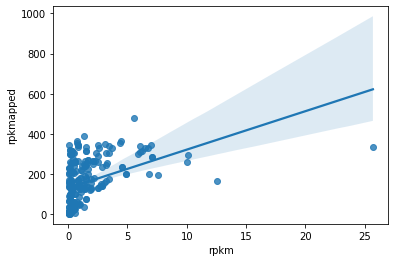

In [12]:
# calculate abundances
filt_results["rpk"] = filt_results.apply(lambda x: (x["filtered_read_pair_count"]*2)/(x["length"]/1000), axis=1)
filt_results["rpkm"] = filt_results.apply(lambda x: x["rpk"]/(x["total_reads"]/1e6), axis=1)
filt_results["rpkmapped"] = filt_results.apply(lambda x: x["rpk"]/(x["mapped_reads"]/1e6), axis=1)
sns.regplot(x="rpkm", y="rpkmapped", data=filt_results)
plt.show()

### probe rubisco coverage

In [ ]:
genes = []

rubiscos = pd.read_csv(rootdir + "rubisco_table.tsv", 
    sep="\t").query("genome_name=='SRR11923207.100.13'")["gene"].to_list()

for record in sfp(open(rootdir + "genomes/filtered/SRR11923207.100.13.genes.faa")):
    name = record[0].split(" # ")[0]
    if name in rubiscos:
        genes.append((name, int(record[0].split(" # ")[1]), int(record[0].split(" # ")[2])))

genes

In [ ]:
def analyze_gene_coverage(bams, genes, nm, mapq):
    
    covinfo = defaultdict(list)
    
    for bam in bams:
    
        for gene in genes:

            coverages = {} #initialize empty cov vec
            for i in range(gene[1], gene[2] + 1):
                coverages[i] = 0

            # take all columns including outside region w/ overlapping reads
            for pileupcolumn in pysam.AlignmentFile(bam, "rb").pileup(
                "_".join(gene[0].split("_")[:-1]),
                gene[1], gene[2], truncate=False,
                min_mapping_quality=mapq, ignore_overlap=False):

                for pileupread in pileupcolumn.pileups:

                    if (not pileupread.is_del and not pileupread.is_refskip
                        and float(pileupread.alignment.get_tag("NM")) <= nm):

                        if pileupcolumn.pos in coverages: # only for those in gene region
                            coverages[pileupcolumn.pos] += 1

            mean_coverage = round(np.mean(list(coverages.values())), 2)
            breadth = len([x for x in coverages.values() if x > 0]) / (float(gene[2] - gene[1]) + 1)

            covinfo["sample"].append(os.path.basename(bam))
            covinfo["gene"].append(gene[0])
            covinfo["mean_coverage"].append(mean_coverage)
            covinfo["breadth"].append(breadth)
    
    return pd.DataFrame(covinfo)

In [16]:
covdf = analyze_gene_coverage(glob.glob(rootdir + "diversity/mapping/*sorted.bam"), genes, 1, 20)

[W::hts_idx_load3] The index file is older than the data file: /scratch/users/ajaffe/photoeco/diversity/mapping/SRR13782125.sorted.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /scratch/users/ajaffe/photoeco/diversity/mapping/SRR13782125.sorted.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /scratch/users/ajaffe/photoeco/diversity/mapping/SRR13782125.sorted.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /scratch/users/ajaffe/photoeco/diversity/mapping/SRR13782125.sorted.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /scratch/users/ajaffe/photoeco/diversity/mapping/SRR5506558.sorted.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /scratch/users/ajaffe/photoeco/diversity/mapping/SRR5506558.sorted.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /scratch/users/ajaffe/photoeco/diversity/mapping/SRR5506558.sorted.bam.bai
[W::hts_idx_load3] The index f

[W::hts_idx_load3] The index file is older than the data file: /scratch/users/ajaffe/photoeco/diversity/mapping/SRR11787837.sorted.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /scratch/users/ajaffe/photoeco/diversity/mapping/SRR11923211.sorted.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /scratch/users/ajaffe/photoeco/diversity/mapping/SRR11923211.sorted.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /scratch/users/ajaffe/photoeco/diversity/mapping/SRR11923211.sorted.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /scratch/users/ajaffe/photoeco/diversity/mapping/SRR11923211.sorted.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /scratch/users/ajaffe/photoeco/diversity/mapping/SRR13782126.sorted.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /scratch/users/ajaffe/photoeco/diversity/mapping/SRR13782126.sorted.bam.bai
[W::hts_idx_load3] The inde

[W::hts_idx_load3] The index file is older than the data file: /scratch/users/ajaffe/photoeco/diversity/mapping/Fuchsman_SRR4465025.sorted.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /scratch/users/ajaffe/photoeco/diversity/mapping/Fuchsman_SRR4465025.sorted.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /scratch/users/ajaffe/photoeco/diversity/mapping/SRR11923212.sorted.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /scratch/users/ajaffe/photoeco/diversity/mapping/SRR11923212.sorted.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /scratch/users/ajaffe/photoeco/diversity/mapping/SRR11923212.sorted.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /scratch/users/ajaffe/photoeco/diversity/mapping/SRR11923212.sorted.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /scratch/users/ajaffe/photoeco/diversity/mapping/AMALJGI-DNA-14.sorted.bam.bai
[W::hts_

[W::hts_idx_load3] The index file is older than the data file: /scratch/users/ajaffe/photoeco/diversity/mapping/SRR3989432.sorted.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /scratch/users/ajaffe/photoeco/diversity/mapping/SRR3989432.sorted.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /scratch/users/ajaffe/photoeco/diversity/mapping/SRR3989432.sorted.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /scratch/users/ajaffe/photoeco/diversity/mapping/ERR3256923.sorted.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /scratch/users/ajaffe/photoeco/diversity/mapping/ERR3256923.sorted.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /scratch/users/ajaffe/photoeco/diversity/mapping/ERR3256923.sorted.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /scratch/users/ajaffe/photoeco/diversity/mapping/ERR3256923.sorted.bam.bai
[W::hts_idx_load3] The index file 

[W::hts_idx_load3] The index file is older than the data file: /scratch/users/ajaffe/photoeco/diversity/mapping/ERR868457.sorted.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /scratch/users/ajaffe/photoeco/diversity/mapping/ERR868457.sorted.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /scratch/users/ajaffe/photoeco/diversity/mapping/AMALJGI-DNA-2.sorted.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /scratch/users/ajaffe/photoeco/diversity/mapping/AMALJGI-DNA-2.sorted.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /scratch/users/ajaffe/photoeco/diversity/mapping/AMALJGI-DNA-2.sorted.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /scratch/users/ajaffe/photoeco/diversity/mapping/AMALJGI-DNA-2.sorted.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /scratch/users/ajaffe/photoeco/diversity/mapping/SRR4465032.sorted.bam.bai
[W::hts_idx_load3] The i

[W::hts_idx_load3] The index file is older than the data file: /scratch/users/ajaffe/photoeco/diversity/mapping/SRR1509793.sorted.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /scratch/users/ajaffe/photoeco/diversity/mapping/SRR1509793.sorted.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /scratch/users/ajaffe/photoeco/diversity/mapping/SRR1509793.sorted.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /scratch/users/ajaffe/photoeco/diversity/mapping/SRR1509793.sorted.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /scratch/users/ajaffe/photoeco/diversity/mapping/Tsementzi_SRR3718412.sorted.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /scratch/users/ajaffe/photoeco/diversity/mapping/Tsementzi_SRR3718412.sorted.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /scratch/users/ajaffe/photoeco/diversity/mapping/Tsementzi_SRR3718412.sorted.bam.bai
[W::

In [49]:
# drop cases where breadth of form II is below threshold
samples_to_drop = covdf.query("gene=='SRR11923207.100.13_scaffold_3_9'").query("breadth<0.50")["sample"]
samples_to_drop = [item.split(".")[0] for item in samples_to_drop]
samples_to_drop

['E87-31-OMZ', 'ETSP13_80m']

## plotting

### samples

In [63]:
# only plot those where AMZ IB is detected and above threshold
found = filt_results[(filt_results["genome"]=="SRR11923207.100.13") & \
                     (~filt_results["sample"].isin(samples_to_drop))][["sample"]]
found = found.merge(mapped[["sample", "latitude", "longitude"]], how="left")
found = found.merge(branchwater[["acc", "lat_lon"]], how="left", left_on="sample", right_on="acc").fillna("None")
# output for curation
found.to_csv(rootdir + "diversity/geo_raw.tsv", sep="\t", index=False)

In [64]:
# read in curated version
curated = pd.read_csv(rootdir + "diversity/geo_curated.tsv", sep="\t").fillna("None")
# remove those from above as well as some additional
curated = curated[(~curated["sample"].isin(samples_to_drop)) & \
                   (curated["depth"]!='None') & (curated["lat"]!='None')]
curated = curated[curated["depth"]<=200]
curated.head(5)

,sample,latitude,longitude,acc,lat_lon,lat,lon,depth,oxygen,notes
1,TARA_SAMEA2620890_METAG,-35.2421,26.3048,None,None,-35.2421,26.3048,30.0,206.4,None
3,ERR3256946,None,None,ERR3256946,NP,-20.0822,-70.8005,65.0,None,None
4,ERR3256923,None,None,ERR3256923,NP,-20.0822,-70.8005,65.0,None,None
5,SRR16028415,None,None,SRR16028415,16.7 S 79 W,-16.7,-79.0,140.0,6.7,None
6,SRR16028410,None,None,SRR16028410,None,-16.7,-79.0,110.0,None,None


In [65]:
# add any manually if difference
set(found["sample"].unique()).difference(curated["sample"].unique())

{'SRR5504448', 'SRR5506659', 'SRR8144072', 'SRR8144073'}

### community composition

In [66]:
palette = {"HL I": "blue", "HL II" :"blue", "HL III":"blue", "HL III/IV": "blue", "HL IV": "blue",
           "LL IV": "#55AA67", "LL I": "#20ED47", "LL II": "#20ED47", "LL III": "#20ED47", "LL II/III": "#20ED47",
           "5.1": "lightblue", "5.1A":"lightblue", "5.1B":"lightblue", "5.2":"lightblue", "5.3":"lightblue", 
           "AMZ IA" : "#C69355", "AMZ IB": "#FF9700", "AMZ II":"#7C470E", "AMZ III":"#F97C00", "unaffiliated": "lightgrey"}

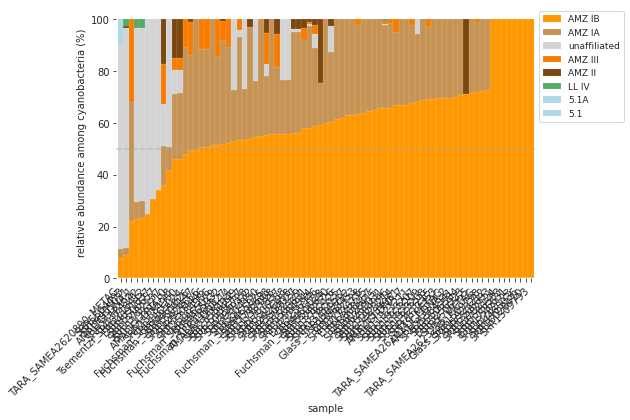

In [84]:
merged = filt_results[filt_results["sample"].isin(curated["sample"])][["sample", "genome", "coverage"]].merge(genomes[["genome_name", 
            "lineage"]], how="left", left_on="genome", right_on="genome_name")
gb = merged.groupby(["sample", "lineage"], as_index=False).aggregate({"coverage":"sum"})
totals = gb.groupby("sample", as_index=False).aggregate({"coverage":"sum"})\
          .rename(columns={"coverage":"total_coverage"})
gb = gb.merge(totals)
gb["perc_total_coverage"] = gb.apply(lambda x: (x["coverage"]/x["total_coverage"])*100, axis=1)
piv = gb.pivot(index="sample", columns="lineage", values="perc_total_coverage").fillna(0)
order = piv.mean(axis=0).sort_values(ascending=False).reset_index()["lineage"].to_list()
sample_order = gb.query("lineage=='AMZ IB'").drop_duplicates("sample").sort_values("perc_total_coverage")["sample"].to_list()
color_map = [palette[item] for item in order]

sns.set_style("ticks")
piv.loc[sample_order,order].plot.bar(color=color_map, width=1,stacked=True, 
    linewidth=0.1, figsize=(7.5,5), legend=None)
plt.ylabel("relative abundance among cyanobacteria (%)")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=9)
sns.despine(bottom="True", left=True)
plt.xticks(rotation=45, ha='right')
plt.axhline(50, linestyle="--", color="darkgrey", alpha=0.5)
plt.savefig(rootdir + "abund.svg", format="svg", dpi=600)
plt.show()

### ticker

In [74]:
def assign_region(row):
    
    if row["lat"] == 'None':
        return "None"
    elif row["lat"] < 0:
        return 3
    elif row["lon"] > -120:
        return 2
    else: return 1
    
curated["region"] = curated.apply(lambda x: assign_region(x), axis=1)

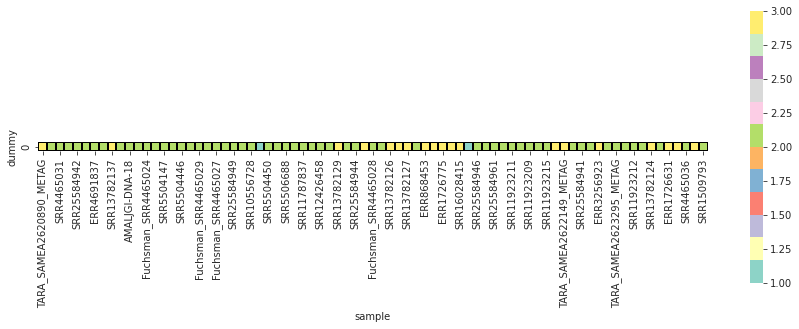

In [104]:
curated["dummy"] = 0

plt.figure(figsize=[15,5])
df = curated.pivot(index="dummy", columns="sample",
                   values="region").replace("None", 0)[sample_order]
sns.heatmap(df, square=True, cmap='Set3', linewidth=0.25, linecolor='black')
plt.savefig(rootdir + "region_ticker.svg", format="svg", dpi=600)

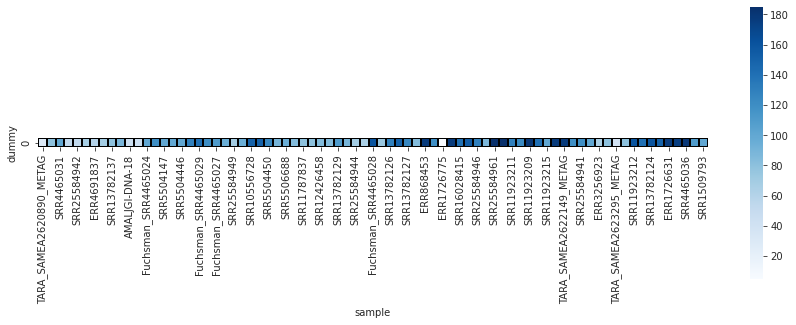

In [110]:
plt.figure(figsize=[15,5])
curated["depth"] = curated["depth"].apply(lambda x: float(x))
df = curated.pivot(index="dummy", columns="sample",
                   values="depth").replace("None", 0)[sample_order]
sns.heatmap(df, square=True, linewidth=0.25, linecolor='black', cmap="Blues")
plt.savefig(rootdir + "depth_ticker.svg", format="svg", dpi=600)

### spatial context

From https://ncar-hackathons.github.io/visualization/cartopy-basics.html

In [4]:
import matplotlib.colors as colors
import xarray as xr
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import numpy as np

In [18]:
ds = xr.open_dataset("/scratch/users/ajaffe/photoeco/diversity/woa18_all_o00_01.nc", decode_times=False)

# compute min o2 per geo bin across all depths
mins = []

for i in range(0,180):
    latbin = []
    for k in range(0,360):
        
        # min across depths
        #all_values = []
        #for depthbin in ds.o_an.data[0]:
        #    all_values.append(depthbin[i][k])
        #latbin.append(np.nanmin(all_values))
        
        # at 125 meters (depth level 22)
        latbin.append(ds.o_an.data[0][21][i][k])
        
    mins.append(latbin)

In [127]:
field, lon = add_cyclic_point(np.array(mins), coord=ds.lon)
lat = ds.lat

In [128]:
# set up colors and contours
levels = [i for i in range(0,400, 10)]
norm = colors.TwoSlopeNorm(vmin=levels[0], vmax=levels[-1], vcenter=60)

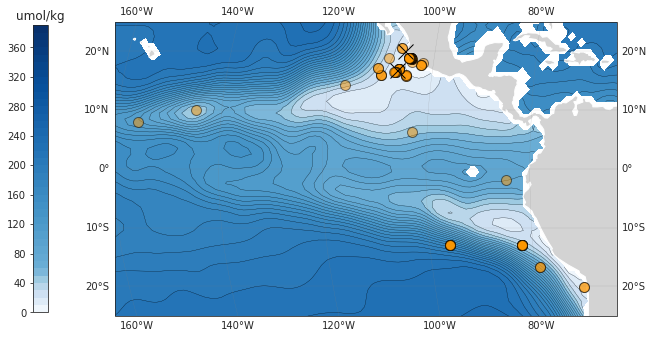

In [129]:
fig = plt.figure(figsize=(12, 16))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=0))

# filled contours
cf = ax.contourf(lon, lat, field, levels=levels, norm=norm, cmap='Blues',
                 transform=ccrs.PlateCarree());

# contour lines
cs = ax.contour(lon, lat, field, colors='k', levels=levels, linewidths=0.25,
                transform=ccrs.PlateCarree())

# add contour labels
#lb = plt.clabel(cs, fontsize=10, inline=True, fmt='%d');

# land
land = ax.add_feature(
    cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='lightgrey'))

#ddf = curated.merge(fsub, how="left").fillna("None").query("rpkm!='None'").query("lat!='None'")
#ddf = ddf.sort_values("rpkm", ascending=False).drop_duplicates(["lat","lon"])
#ddf["rpkm_norm"] = ddf.apply(lambda x: math.log10(x["rpkm"])/math.log10(max(ddf["rpkm"])), axis=1)

for key, row in curated.query("lat!='None'").iterrows():
    plt.plot(row["lon"], row["lat"],color="black", markerfacecolor='#FF9700',
             marker="o",transform=ccrs.PlateCarree(), markersize=10, alpha=0.5)
    
for coord in [[20.150000, -106.000000], [16.900000, -107.000000]]:
    plt.plot(coord[1], coord[0],color="black",
             marker="x",transform=ccrs.PlateCarree(), markersize=15, alpha=1)
        
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.25, color='gray', alpha=0.5, linestyle='-')

# colorbar and labels
cb = plt.colorbar(cf, shrink=0.33, location="left")
cb.ax.set_title('umol/kg')
ax.set_extent([-160, -65, -25, 25], crs=ccrs.PlateCarree())
#ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
plt.savefig(rootdir + "local_geo.svg", format="svg", dpi=600)
plt.show()

### export for supp

In [124]:
curated.to_csv(rootdir + "supp/geo_filtered.tsv", sep="\t", index=False)
filt_results.to_csv(rootdir + "supp/filt_results.tsv", sep="\t", index=False)
piv.reset_index().to_csv(rootdir + "supp/relative_abundance.tsv", sep="\t", index=False)

### depth profiles

In [6]:
transect = pd.read_csv(rootdir + "mra_table1.csv")
samples = ["304420_S9", "304422_S11", "304423_S12", "304427_S16"]
transect_subset = transect[transect["Metatranscriptome"].isin(samples)]
transect_subset

,Metatranscriptome,SRA accession no.,BioSample no.,CTD cast; station,Collection date (yr-mo-day),Collection time (UTC)a,Local collection time (UTC-6)a,Depth (m),DO (µM),Sample typea,No. of spots (reads),No. of bases
8,304420_S9,SRR14460573,SAMN19065212,59; P1,4/21/18,15:35,9:35,77.0,0.66,SCM,"22,226,093","6,667,827,900"
10,304422_S11,SRR14460585,SAMN19065214,63; P1,4/23/18,14:00,8:00,40.0,8.60,Low DO,"25,320,982","7,596,294,600"
11,304423_S12,SRR14460584,SAMN19065215,64; P1,4/24/18,14:03,8:03,126.0,1.00,Nitrite max,"25,828,575","7,748,572,500"
15,304427_S16,SRR14460580,SAMN19065219,72; P1,4/27/18,9:42,3:42,28.0,33.00,High DO,"30,533,274","9,159,982,200"


In [7]:
env_data = pd.read_csv(rootdir + "station33_cast59_1db.csv")
# make 1 m depth bins
env_data["depth_bin"] = env_data["depth"].apply(np.floor)
env_data_binned = env_data.groupby("depth_bin", 
                    as_index=False).aggregate({"par":"mean", "fluorescence":"mean", "oxygen2":"mean"})

In [8]:
env_data_binned["depth_negative"] = env_data_binned["depth_bin"].apply(lambda x: int(x*-1))
env_data_binned["percent_par"] = env_data_binned["par"].apply(lambda x: x/max(env_data_binned["par"])*100)

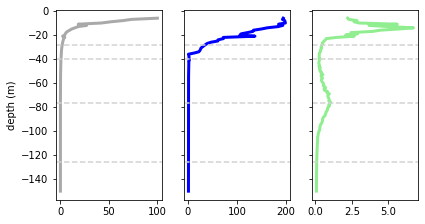

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(6.5, 3.5))
env_data_binned = env_data_binned.query("depth_negative>=-150")
ax1.plot(env_data_binned["percent_par"], env_data_binned["depth_negative"], color="darkgrey", linewidth=3)
ax2.plot(env_data_binned["oxygen2"], env_data_binned["depth_negative"], color="blue",linewidth=3)
ax3.plot(env_data_binned["fluorescence"], env_data_binned["depth_negative"], color="lightgreen",linewidth=3)

for ax in fig.get_axes():
    
    ax.label_outer()
    
    for key, row in transect_subset.iterrows():
        ax.axhline(row["Depth (m)"]*-1, linestyle='--', color="lightgrey")

ax1.set_ylabel("depth (m)")
plt.savefig(rootdir + "env_sep.svg", format="svg")
plt.show()